In [1]:
# Content from Proakis
# Code © 2019, Alexander Kain
import numpy as np
from scipy.signal import unit_impulse, lfilter, tf2sos, sosfilt
from matplotlib import pyplot as plt
%matplotlib inline

## 9.3 Structures for IIR systems
### 9.4.1. Direct Form Structures

Given the system

$$ y[n] = \sum_{k=0}^M b_k x[n-k] - \sum_{k=1}^N a_k y[n-k] $$

the rational system function

$$ H(z) = \frac{\sum_{k=0}^M b_k z^{-k}}
{1 + \sum_{k=1}^N a_k z^{-k}} $$

can be viewed as two systems in cascade

$$ H(z) = H_z(z) H_p(z) $$

where

$$ H_z(z) = \sum_{k=0}^M b_k z^{-k} $$

and

$$ H_p(z) = \frac{1}{1 + \sum_{k=1}^N a_k z^{-k}} $$

This requires $M+N+1$ multiplications, $M+N$ additions, and $M+N+1$ memory locations. It is called *Direct Form I*.

![](Fig9.3.1.jpeg)

In [2]:
def iir_filter(b, a, x):
    Nb = len(b)
    Na = len(a)
    zb = np.zeros(Nb - 1)
    za = np.zeros(Na - 1)
    y = np.empty_like(x)
    for i in range(len(y)):
        y[i] = b[0] * x[i] + (b[1:] * zb).sum() - (a[1:] * za).sum()
        if Nb > 1: 
            zb[1:] = zb[:-1]  # shift stack
            zb[0] = x[i]  # feed stack
        if Na > 1: 
            za[1:] = za[:-1]  # shift stack
            za[0] = y[i]  # feed stack
    return y

x = unit_impulse(7)
b = np.array([1])
a = np.array([1, 0.1])
y = iir_filter(b, a, x)
y

array([ 1.e+00, -1.e-01,  1.e-02, -1.e-03,  1.e-04, -1.e-05,  1.e-06])

In [3]:
# using the library
y2 = lfilter(b, a, x)  # but the implementation for this is different, see below
assert np.allclose(y2, y)

If we swap the two components, a more compact structure is obtained, requiring the same amount of multiplications and additions, but only $\max(M, N)$ memory locations. It is called *Direct Form II*. 

![](Fig9.3.2.jpeg)

This form implements the all-pole filter via the intermediate sequence (the last values of which can be found in the delays)

$$ w[n] = - \sum_{k=1}^N a_k w[n-k] + x[n] $$

which is then input to the all-zero system

$$ y[n] = \sum_{k=0}^{M} b_k w[n-k] $$

The two forms are theoretically equivalent. Direct form I only has one summation point, which can work well if a fixed-point implementation is necessary because the accumulator can safely over/underflow.

Unfortunately, both direct forms are sensitive to parameter quantization when using large $M$ or $N$, and are not recommended in practical applications.

### 9.3.2 Signal Flow Graphs and Transposed Structures

The subject of linear signal flow graphs provides the *transposition* or *flow-graph reversal theorem*, which states that if we reverse the directions of all branch transmittances and interchange the input and output in the flow graph, the system function remains unchanged.

We can apply the transposition theorem to the direct form II structure (since it is more compact):

![](Fig9.3.5.jpeg)

Now let's redraw it so that the input is on the left and the output is on the right:

![](Fig9.3.6.jpeg)

The transposed direct form II is most often used in practice because it combines best numerical stability with fewest delays, and thus this is the implementation used for `scipy.signal.lfilter`.

### 9.3.3 Cascade-Form Structures

As for the FIR systems, we can factor the system function into a cascade of second-order systems (SOS)

$$ H(z) = \prod_{k=1}^K H_k(z) $$

where

$$ H_k(z) = \frac{b_{k,0} + b_{k,1} z^{-1} + b_{k,2}z^{-2}}
{1 + a_{k,1}z^{-1} + a_{k,2}z^{-2}} $$

Similar to the FIR case, it is desireable to form pairs of complex-conjugate roots so that the coefficients remain real-valued; real-valued roots can be paired in an arbitrary manner.

The advantage of this structure is that it can provide better numerical precision.

![](Fig9.3.8.jpeg)

In [4]:
b = np.array([9, 7, 5, 3, -1, 2])
a = np.array([1, 0.1, -0.5, 0.1])
sos = tf2sos(b, a)
sos

array([[ 9.        ,  4.50159008,  6.8153597 ,  1.        ,  0.        ,
         0.        ],
       [ 1.        , -0.67787104,  0.30713067,  1.        , -0.23851648,
         0.        ],
       [ 1.        ,  0.95547214,  0.        ,  1.        ,  0.33851648,
        -0.41925824]])

In [5]:
y1 = sosfilt(sos, x)
y2 = lfilter(b, a, x)
assert np.allclose(y1,  y2)

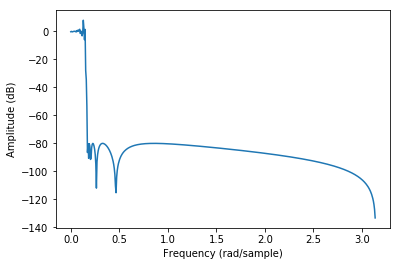

In [6]:
# example from scipy.signal.sosfilt documentation,
# showing the instability that results from trying to 
# do a 13th-order filter in a single stage,
# the numerical error pushes some poles outside of the unit circle
from scipy.signal import ellip, freqz  # this designs a specific filter (discussed later)

b, a = ellip(13, 0.009, 80, 0.05, output='ba')
sos  = ellip(13, 0.009, 80, 0.05, output='sos')

w, H = freqz(b, a)
plt.plot(w, 20 * np.log10(abs(H)))
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/sample)');

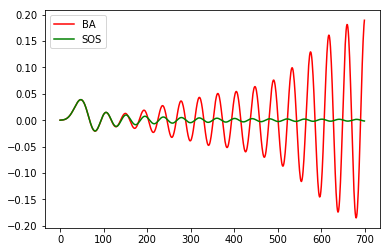

In [7]:
x = unit_impulse(700)
y_ba = lfilter(b, a, x)
y_sos = sosfilt(sos, x)
plt.plot(y_ba,  'r', label='BA')  # unstable!
plt.plot(y_sos, 'g', label='SOS')
plt.legend();

### 9.3.4 Parallel-Form Structures

By performing a *partial-fraction expansion* (PFE), we can rewrite the rational system function $H(z)$ as a sum of fractions with a simple denominator, plus another polynomial term:

$$ H(z) = \frac{\sum_{k=0}^M b_k z^{-k}}
{1 + \sum_{k=1}^N a_k z^{-k}} = \sum_{k=1}^N \frac{r_k}{1 - p_kz^{-1}} + C(z)$$

where $r_k$ are the residues, $p_k$ are the poles, and $C(z)$ is an extra FIR filter with system function $C(z)$.

An example of PFE:

$$ H(z) = \frac{B(z)}{A(z)} = \frac{1}{1 + 2z^{-1} - 3z^{-2}} $$

the denominator splits into two factors

$$ A(z)=1 + 2z^{-1} - 3z^{-2}=(1 + 3z^{-1})(1 - z^{-1}) $$

which leads to the partial fraction expansion

$$ H(z)=\frac{1}{1 + 2z^{-1} - 3z^{-2}} =\frac{r_1}{1 + 3z^{-1}}+\frac{r_2}{1 - z^{-1}} $$

Multiplying through by the denominator on the left-hand side gives the polynomial identity

$$ 1=r_1(1-z^{-1})+r_2(1+3z^{-1}) $$

Substituting $z^{-1} = -1/3$ into this equation gives $r_1 = 3/4$, and substituting $z = 1$ gives $r_2 = 1/4$, so that

$$ H(z)=\frac{1}{1 + 2z^{-1} - 3z^{-2}} =\frac{\frac{3}{4}}{1 + 3z^{-1}}+\frac{\frac{1}{4}}{1 - z^{-1}} $$

$C(z) = 0$ in this example.

In [8]:
# in practice we use use a library call to do this
from scipy.signal import residuez

r, p, C = residuez([1],[1, 2, -3])  
r, p, C

(array([0.75, 0.25]), array([-3.,  1.]), array([0.]))

![](Fig9.3.9.jpeg)

This structure is also less sensitive to filter coefficient quantization than the direct forms.

In [9]:
x = unit_impulse(7)
b = np.array([9, 7, 5, 3, -1, 2])
a = np.array([1, 0.1, -0.5, 0.1])

r, p, C = residuez(b, a)
r, p, C

(array([  -2.03515539, -531.10770176,   82.14285714]),
 array([-0.83851648,  0.23851648,  0.5       ]),
 array([460.,  90.,  20.]))

In [10]:
B = np.atleast_2d(r).T  # make 2D, rows contains b coeffs
A = np.atleast_2d([np.poly(p) for p in p])  # rows contain a coeffs
B, A

(array([[  -2.03515539],
        [-531.10770176],
        [  82.14285714]]), array([[ 1.        ,  0.83851648],
        [ 1.        , -0.23851648],
        [ 1.        , -0.5       ]]))

In [11]:
def pfe_filter(B, A, C, x):
    y = lfilter(C, [1], x)
    for k in range(B.shape[0]):
        y += lfilter(B[k], A[k], x)
    return y

assert np.allclose(pfe_filter(B, A, C, x), 
                   lfilter(b, a, x))

If $H(z)$ has complex poles, we create second-order systems and form pairs of complex-conjugate poles (and arbitrarily real-valued roots) so that the coefficients remain real-valued.

Overall, the cascade form is more robust and should be the preferred choice in practical applications, especially where a fixed-point representation is employed.

### 9.3.5 Lattice and Lattice-Ladder Structures for IIR Systems

Given an $N^\textrm{th}$ all-zero FIR filters with the difference equation

$$ y[n] = x[n] + \sum_{k=1}^{N} \alpha_m [k] x[n-k]$$

with input $x[n]$ and output $y[n]$. If we interchange the roles of input and output we obtain

$$ x[n] = y[n] + \sum_{k=1}^{N} \alpha_m [k] y[n-k]$$

or equivalently

$$ y[n] = x[n] -  \sum_{k=1}^{N} \alpha_m [k] y[n-k] $$

which is an all-pole IIR system.

We will apply this approach to the FIR lattice lattice described previously by letting the input

$$ x[n] = f_N[n] $$

and the output

$$ y[n] = f_0[n] $$

These are the exact opposite of the all-zero lattice filter definition, and thus the computations for $f_m[n]$ must be performed in reverse

$$ f_{m-1}[n] = f_m[n] - K_m g_{m-1} [n-1] $$

while $g_m[n]$ remains the same, as well as the lattice parameters $K$ and their conversion algorithms.

![](Fig9.3.13.jpeg)

To create a structure that implements both poles and zeros, a *ladder* part can be added to the all-pole system, adding a weighted linear combination of $g_m[n]$ via ladder parameters $v$ that control the zeros of the system

$$ y[n] = \sum_{m=0}^M v_m g_m[n] $$

![](Fig9.3.16.jpeg)

where $v_m$ are calculated via a recursive formula.